# Реализация класса Dataset для генерации данных для обучения модели классификации ортогонального поворота текста (OCR)
- Автор: Кирилл Киселев
- Дата начала: 22.06.2022
- Цель: реализовать кастомный датасет, который берет фотографию из папки, вырезает из нее кусок, поворачивает, размечает и возвращает размеченную картинку.

In [1]:
!pip list

Package              Version
-------------------- ------------
argon2-cffi          21.3.0
argon2-cffi-bindings 21.2.0
asttokens            2.0.5
attrs                21.4.0
backcall             0.2.0
beautifulsoup4       4.10.0
bleach               4.1.0
boto3                1.24.0
botocore             1.27.0
certifi              2022.5.18.1
cffi                 1.15.0
charset-normalizer   2.0.12
debugpy              1.6.0
decorator            5.1.1
defusedxml           0.7.1
entrypoints          0.4
executing            0.8.3
idna                 3.3
imutils              0.5.4
ipykernel            6.10.0
ipython              8.2.0
ipython-genutils     0.2.0
ipywidgets           7.7.1
jedi                 0.18.1
Jinja2               3.1.1
jmespath             1.0.0
jsonschema           4.4.0
jupyter-client       7.2.1
jupyter-core         4.9.2
jupyterlab-pygments  0.1.2
jupyterlab-widgets   1.1.1
MarkupSafe           2.1.1
matplotlib-inline    0.1.3
mistune              0.8.4
nbclien

## 1. Загруза необходимых библиотек

In [2]:
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import RandomCrop, ToTensor, Grayscale
from sklearn.model_selection import train_test_split
import random
from typing import List
from PIL import Image
from pathlib import Path
import numpy as np
import cv2
import os
from openvino.inference_engine import IECore

import torchvision
import torch

import torch.optim as optim
import torch.nn as nn
from tqdm import tqdm

import pytesseract
from pytesseract import Output

from sklearn.metrics import accuracy_score

/home/kirillk/PycharmProjects/ocr_data_generation/venv/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


ModuleNotFoundError: No module named 'openvino'

In [23]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [24]:
torch.cuda.is_available()

True

## 2. Глобальные перменные

In [12]:
BATCH_SIZE = 32
list_path = [*Path('/home/kirillk/datasets/OCR/ocr_ortho_classifier/').glob('*jpg')]

## 3. Необходимые функции

In [5]:
def plot(imgs, with_orig=True, row_title=None, **imshow_kwargs):
    if not isinstance(imgs[0], list):
        # Make a 2d grid even if there's just 1 row
        imgs = [imgs]

    num_rows = len(imgs)
    num_cols = len(imgs[0]) + with_orig
    fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, squeeze=False)
    for row_idx, row in enumerate(imgs):
        row = [orig_img] + row if with_orig else row
        for col_idx, img in enumerate(row):
            ax = axs[row_idx, col_idx]
            ax.imshow(np.asarray(img), **imshow_kwargs)
            ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

    if with_orig:
        axs[0, 0].set(title='Original image')
        axs[0, 0].title.set_size(8)
    if row_title is not None:
        for row_idx in range(num_rows):
            axs[row_idx, 0].set(ylabel=row_title[row_idx])

    plt.tight_layout()

## 4. Предварительные исследования

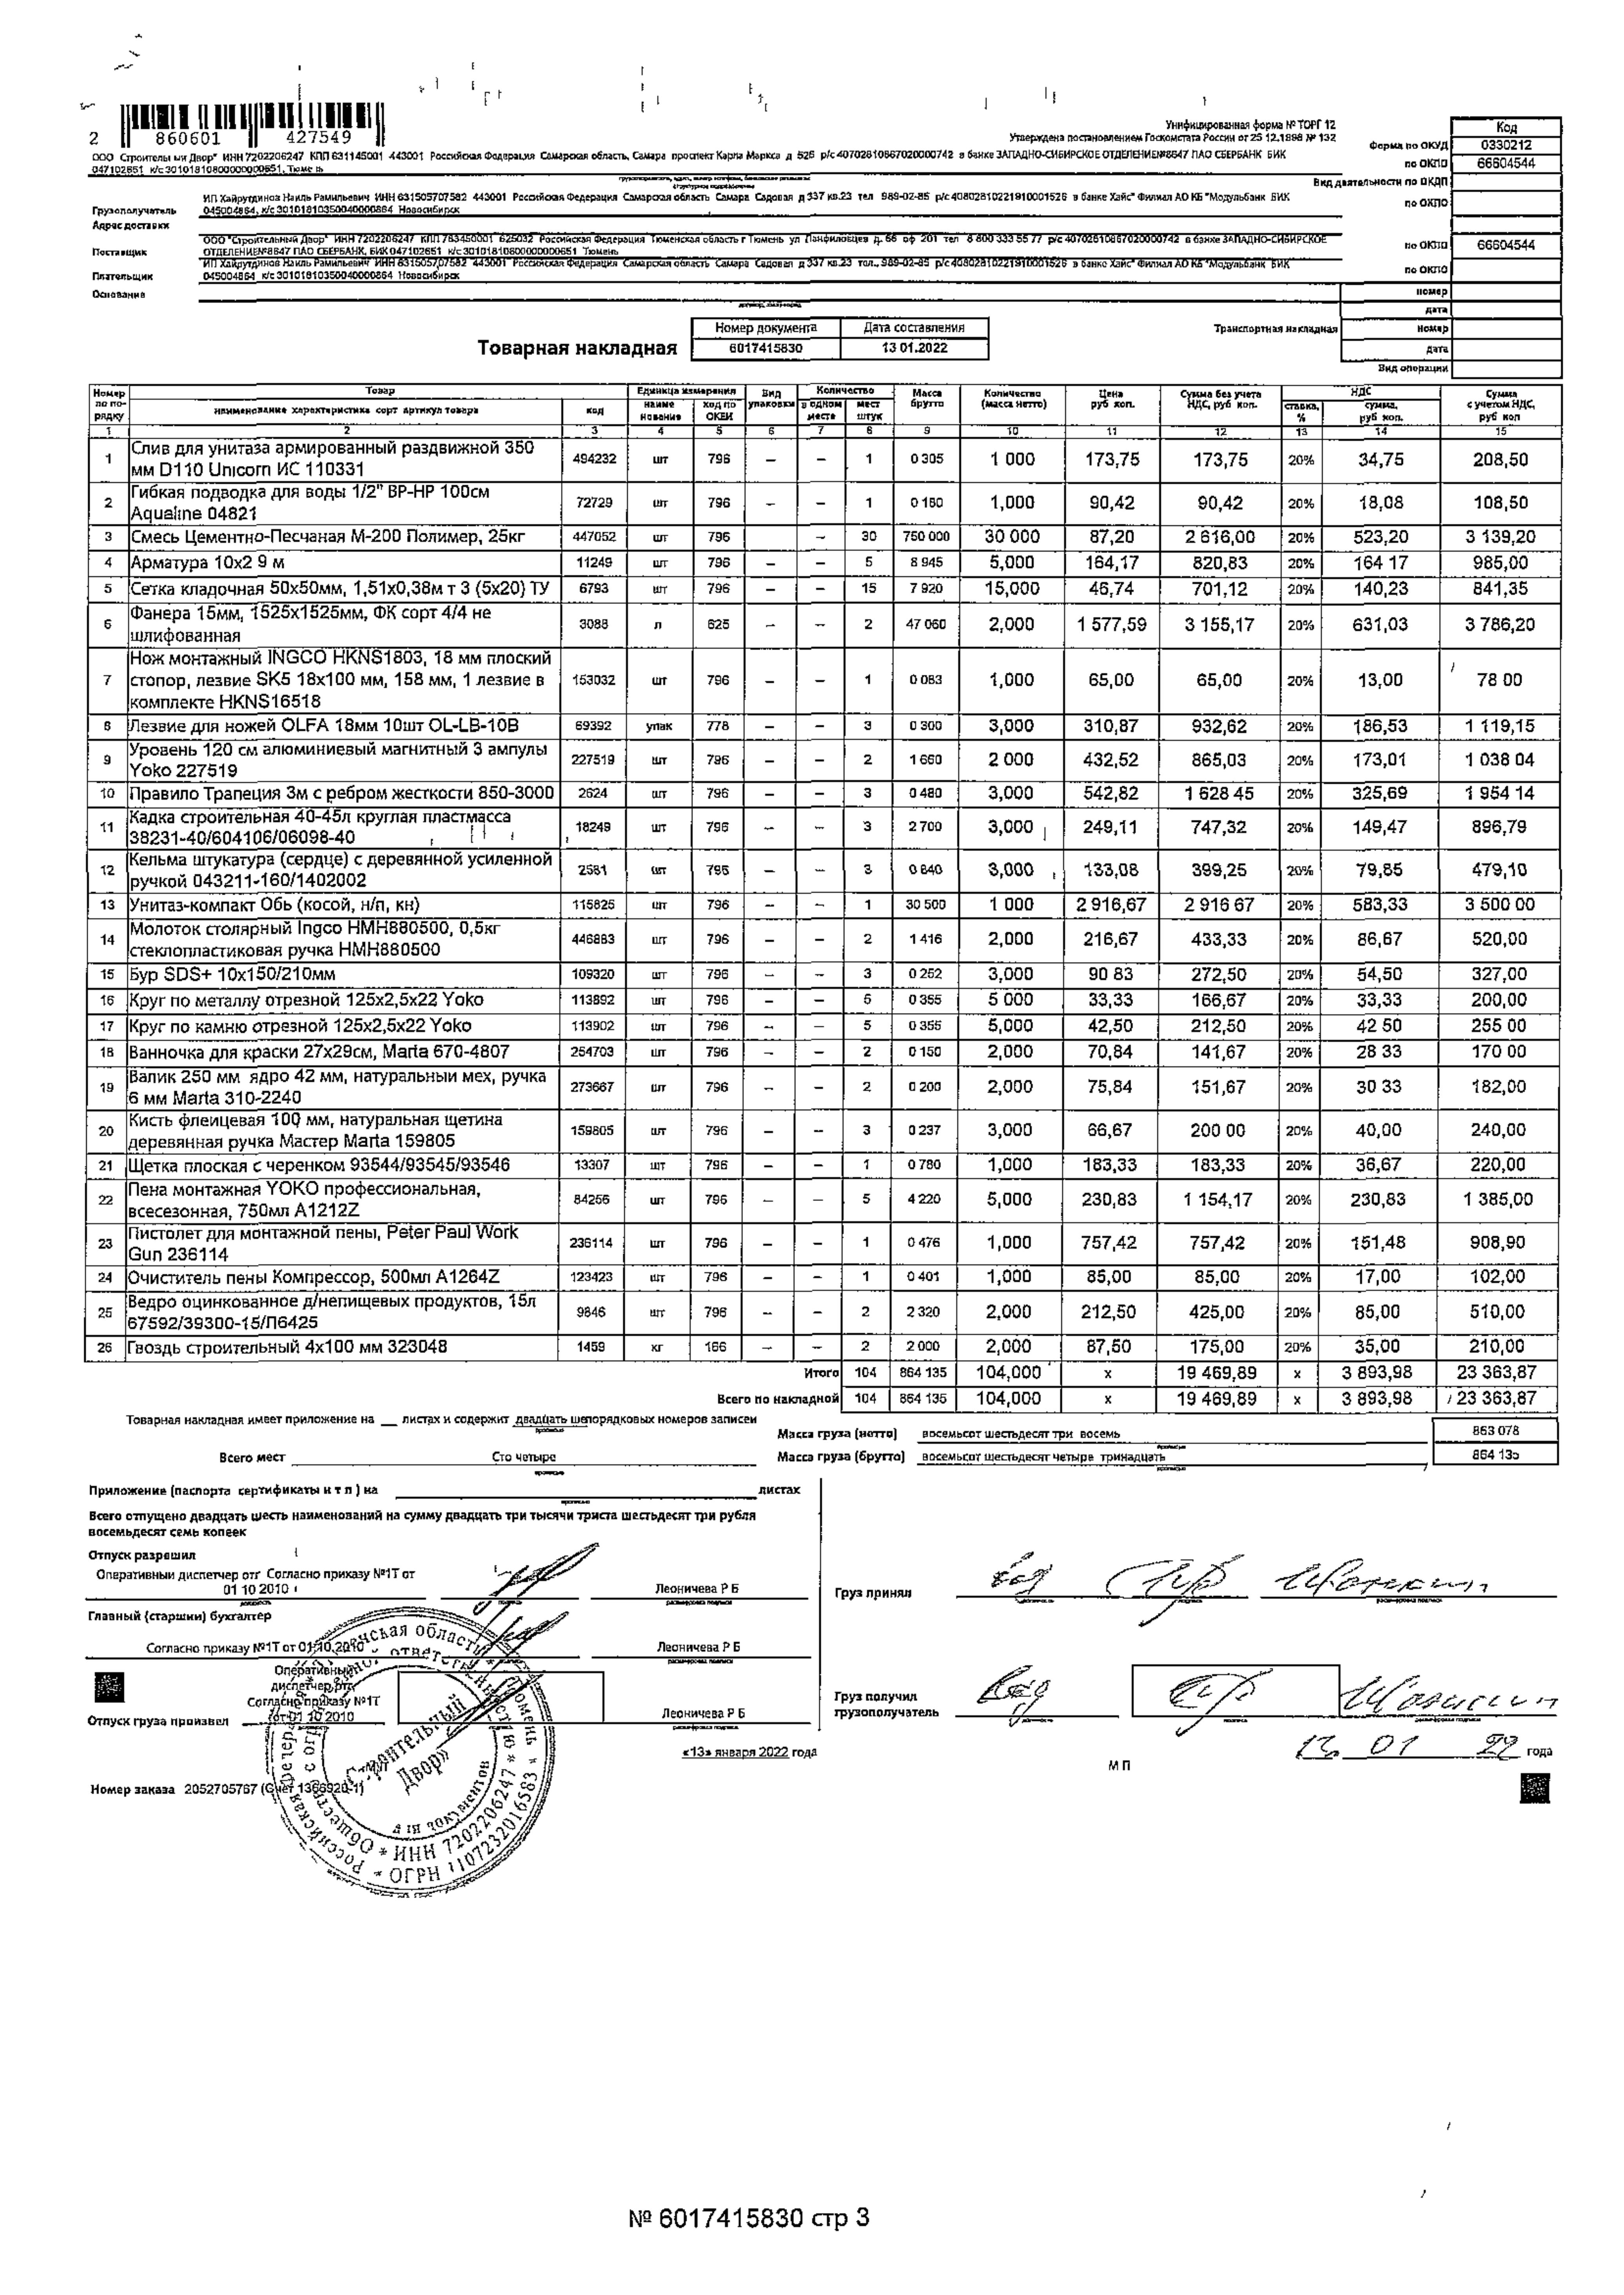

In [6]:
orig_img = Image.open(data_list[0])
orig_img

In [21]:
np.asarray(orig_img).mean()

232.4174714737474

### Работа с кропами

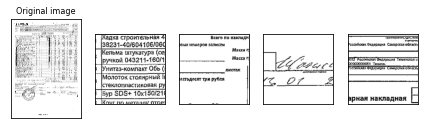

In [27]:
cropper = RandomCrop(size=(500, 500))
crops = [cropper(orig_img) for _ in range(4)]
plot(crops)

In [28]:
for crop in crops:
    gray_crop = Grayscale()(crop)
    print(np.asarray(gray_crop).mean())
#     print(ToTensor()(crop).numpy().mean())

193.238212
237.015288
240.215332
210.427392


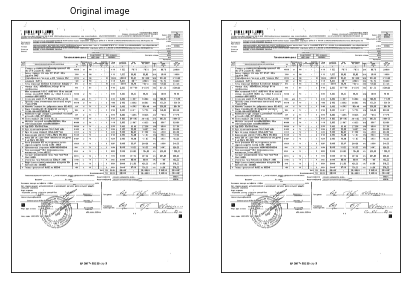

In [12]:
gray_img = Grayscale()(orig_img)
plot([gray_img], cmap='gray')

In [13]:
gray_crop = Grayscale()(crops[0])

In [14]:
gray_tensor = ToTensor()(gray_crop).numpy()
gray_tensor.mean()

0.9997413

In [15]:
gray_tensor.mean() < 0.9

False

### Вывод:
Среднее значение полностью белого кропа равно 1.
Предварительный порог белого 0.9

### Работа с поворотом

In [16]:
rotated_crops = []

for crop in crops:
    rotated_crops.append(crop.rotate(270))

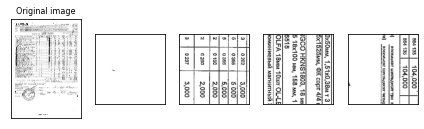

In [17]:
plot(rotated_crops)

## 5. Реализация класса Dataset

In [14]:
class DataGenerationDataset(Dataset):
    def __init__(self,
                 img_list: List[Path],
                 crop_size: int,
                 white_threshold: int,
                 transform: bool = False,
                 transform_list: List[int] = []):

        self.transform = transform
        self.image_list = img_list
        self.crop_size = crop_size
        self.white_threshold = white_threshold
        self.transform_list = transform_list
        self.label_dict = {0: 0, 90: 1, 180: 2, 270: 3}

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx: int):
        img_path = self.image_list[idx]

        image = Image.open(img_path)

        transform = RandomCrop(size=(self.crop_size, self.crop_size))

        flag = True

        while flag:
            crop = transform(image)
            gray_tensor_mean = np.asarray(Grayscale()(crop)).mean()
            # print(gray_tensor_mean)
            if gray_tensor_mean < self.white_threshold:
                flag = False
        # print(gray_tensor_mean)
        if self.transform:
            assert self.transform_list != []
            rotation_angle = random.choice(self.transform_list)
            # print(rotation_angle)
            cv_image = cv2.cvtColor(np.array(crop), cv2.COLOR_RGB2BGR)
            cv_image = cv2.GaussianBlur(cv_image, (7, 7), 0)
            i_icv_imagem = cv2.normalize(cv_image, cv_image, 0, 255, norm_type=cv2.NORM_MINMAX)
            cv_image = cv2.cvtColor(cv_image, cv2.COLOR_BGR2RGB)
            crop = Image.fromarray(cv_image)
            
            crop = crop.rotate(rotation_angle)
            tensor = ToTensor()(crop)
        else:
            rotation_angle = 0
        # print(np.asarray(crop).shape)
        # cv2.imshow('crop', np.asarray(crop))
        # cv2.waitKey()
        # cv2.destroyAllWindows()
        return tensor, self.label_dict[rotation_angle]


In [16]:
for _ in range(20):    
    test = DataGenerationDataset(list_path, 500, 240, True, [0, 90, 180, 270])
    test[0]

## 6. Реализация DataLoader

In [18]:
train_paths, val_paths = train_test_split(list_path, test_size=0.2)

train_dataset = DataGenerationDataset(
    train_paths, 500, 240, True, [0, 90, 180, 270])
val_dataset = DataGenerationDataset(
    val_paths, 500, 240, True, [0, 90, 180, 270])

train_dataloader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE,
    shuffle=True, num_workers=0)
val_dataloader = DataLoader(
    val_dataset, batch_size=BATCH_SIZE,
    shuffle=True, num_workers=0)

In [3]:
train_features, train_labels = next(iter(dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]

plt.imshow(img, cmap='gray')
plt.show()
print(img.shape)
print(f"Label: {label}")


NameError: name 'dataloader' is not defined

In [19]:
net = torchvision.models.mobilenet_v3_small(pretrained=True)
net.fc=torch.nn.Linear(in_features=512, out_features=4, bias=True)
# net.cuda()
# net = torchvision.models.mobilenet_v3_small(pretrained=True)
net.classifier[-1] = torch.nn.Linear(in_features=1024, out_features=4, bias=True)
# net.cuda()

In [25]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(net.parameters(), lr=0.001)
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
total = 0
correct = 0
accuracy_list = []

for epoch in range(100):  # loop over the dataset multiple times
    net.train()
    print(epoch)
    running_loss = 0.0
    for i, data in enumerate(train_dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        # print(outputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 100 == 99:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 100))
            running_loss = 0.0
    with torch.no_grad():
        net.eval()
        for data in val_dataloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)

            # calculate outputs by running images through the network
            outputs = net(images)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy_list.append(100 * correct / total)
    print(f'Accuracy of the network on the {len(val_dataset)} test images: {100 * correct / total}' )

print('Finished Training')

0


RuntimeError: CUDA error: all CUDA-capable devices are busy or unavailable
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.